In [1]:
# Libraries
suppressPackageStartupMessages({
    library(DropletUtils)
    library(SingleCellExperiment)
    library(scater)
    options(stringsAsFactors = FALSE)
    
})

In [2]:
#rm(sce)
sce <- read10xCounts("data/filtered_gene_bc_matrices/hg19/")
sce

class: SingleCellExperiment 
dim: 32738 2700 
metadata(1): Samples
assays(1): counts
rownames(32738): ENSG00000243485 ENSG00000237613 ... ENSG00000215616
  ENSG00000215611
rowData names(2): ID Symbol
colnames: NULL
colData names(2): Sample Barcode
reducedDimNames(0):
altExpNames(0):

In [3]:
# Annotating the rows
#library(scater)
rownames(sce) <- uniquifyFeatureNames(rowData(sce)$ID, rowData(sce)$Symbol)
head(rownames(sce))

[1] "MIR1302-10"   "FAM138A"      "OR4F5"        "RP11-34P13.7" "RP11-34P13.8"
[6] "AL627309.1"

In [4]:
library(EnsDb.Hsapiens.v75)
location <- mapIds(EnsDb.Hsapiens.v75, keys=rowData(sce)$ID, 
    column="SEQNAME", keytype="GENEID")

Loading required package: ensembldb

Loading required package: GenomicFeatures

Loading required package: AnnotationDbi

Loading required package: AnnotationFilter


Attaching package: 'ensembldb'


The following object is masked from 'package:stats':

    filter




In [6]:
sce <- perCellQCMetrics(sce)

In [8]:
colnames(sce)

[1] "sum"      "detected" "total"

In [9]:
plotPlatePosition

function (object, plate_position = NULL, colour_by = NULL, size_by = NULL, 
    shape_by = NULL, by_exprs_values = "logcounts", add_legend = TRUE, 
    theme_size = 24, point_alpha = 0.6, point_size = 24, other_fields = list(), 
    swap_rownames = NULL) 
{
    if (!is(object, "SingleCellExperiment")) {
        stop("Object must be of class SingleCellExperiment")
    }
    if (!is.list(plate_position)) {
        if (is.null(plate_position)) {
            plate_position <- object$plate_position
        }
        if (any(!grepl("^[A-Z][0-9]+$", plate_position))) {
            stop("invalid format specified in 'plate_position'")
        }
        y_position <- gsub("[0-9]*", "", plate_position)
        x_position <- as.integer(gsub("[A-Z]*", "", plate_position))
    }
    else {
        x_position <- as.integer(plate_position$column)
        y_position <- as.character(plate_position$row)
        plate_position <- NULL
    }
    x_position <- as.factor(x_position)
    y_position <- factor(y_position, levels = rev(LETTERS))
    df_to_plot <- data.frame(X = x_position, Y = y_position)
    vis_out <- .incorporate_common_vis_col(df_to_plot, se = object, 
        colour_by = colour_by, shape_by = shape_by, size_by = size_by, 
        by_exprs_values = by_exprs_values, other_fields = other_fields, 
        swap_rownames = swap_rownames)
    df_to_plot <- vis_out$df
    colour_by <- vis_out$colour_by
    shape_by <- vis_out$shape_by
    size_by <- vis_out$size_by
    plot_out <- ggplot(df_to_plot, aes_string(x = "X", y = "Y"))
    point_out <- .get_point_args(colour_by, shape_by, size_by, 
        alpha = point_alpha, size = point_size)
    plot_out <- plot_out + do.call(geom_point, point_out$args)
    if (!is.null(colour_by)) {
        plot_out <- .resolve_plot_colours(plot_out, df_to_plot$colour_by, 
            colour_by, fill = point_out$fill)
    }
    plot_out <- plot_out + theme_bw(theme_size) + theme(axis.title = element_blank(), 
        axis.ticks = element_blank(), legend.text = element_text(size = theme_size/2), 
        legend.title = element_text(size = theme_size/2)) + guides(fill = guide_legend(override.aes = list(size = theme_size/2)))
    plot_out <- .add_extra_guide(plot_out, shape_by, size_by)
    if (!add_legend) {
        plot_out <- plot_out + theme(legend.position = "none")
    }
    plot_out
}
<bytecode: 0x55979dc7f5c0>
<environment: namespace:scater>

### Manually

In [46]:
unfiltered <- sce

In [47]:
stats <- perCellQCMetrics(sce, subsets=list(Mito=which(location=="MT")))
high.mito <- isOutlier(stats$subsets_Mito_percent, type="higher")
sce <- sce[,!high.mito]

In [55]:
library(scuttle)
is.mito <- grep("MT", rownames(sce))

per.cell <- perCellQCMetrics(sce, subsets=list(Mito=is.mito))
colnames(per.cell)
per.cell[1:3,]

[1] "sum"                   "detected"              "subsets_Mito_sum"     
[4] "subsets_Mito_detected" "subsets_Mito_percent"  "total"

DataFrame with 3 rows and 6 columns
        sum  detected subsets_Mito_sum subsets_Mito_detected
  <numeric> <integer>        <numeric>             <integer>
1      2421       781               82                    18
2      4903      1352              201                    24
3      3149      1131               44                    19
  subsets_Mito_percent     total
             <numeric> <numeric>
1              3.38703      2421
2              4.09953      4903
3              1.39727      3149

In [56]:

summary(per.cell$sum)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    561    1792    2221    2399    2774   15844 

In [57]:

summary(per.cell$detected)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  212.0   702.5   822.0   855.8   958.0  3422.0 

In [59]:
summary(per.cell$subsets_Mito_percent)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3067  1.9612  2.4696  2.5542  3.0522  6.7396 

In [60]:
# There is no spike-in values
summary(per.cell$altexps_ERCC_percent)

Length  Class   Mode 
     0   NULL   NULL 

In [61]:
colData(sce) <- cbind(colData(sce), per.cell)
colnames(colData(sce))

[1] "Sample"                "Barcode"               "sum"                  
[4] "detected"              "subsets_Mito_sum"      "subsets_Mito_detected"
[7] "subsets_Mito_percent"  "total"

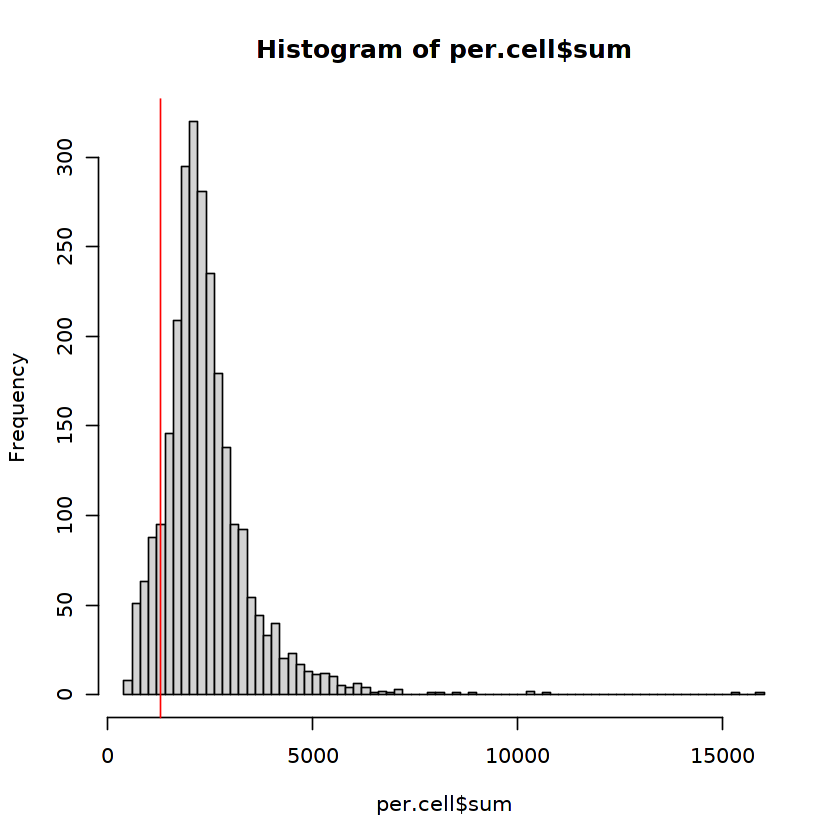

In [65]:
hist(
    per.cell$sum,
    breaks = 100
)
abline(v = 1300, col = "red")

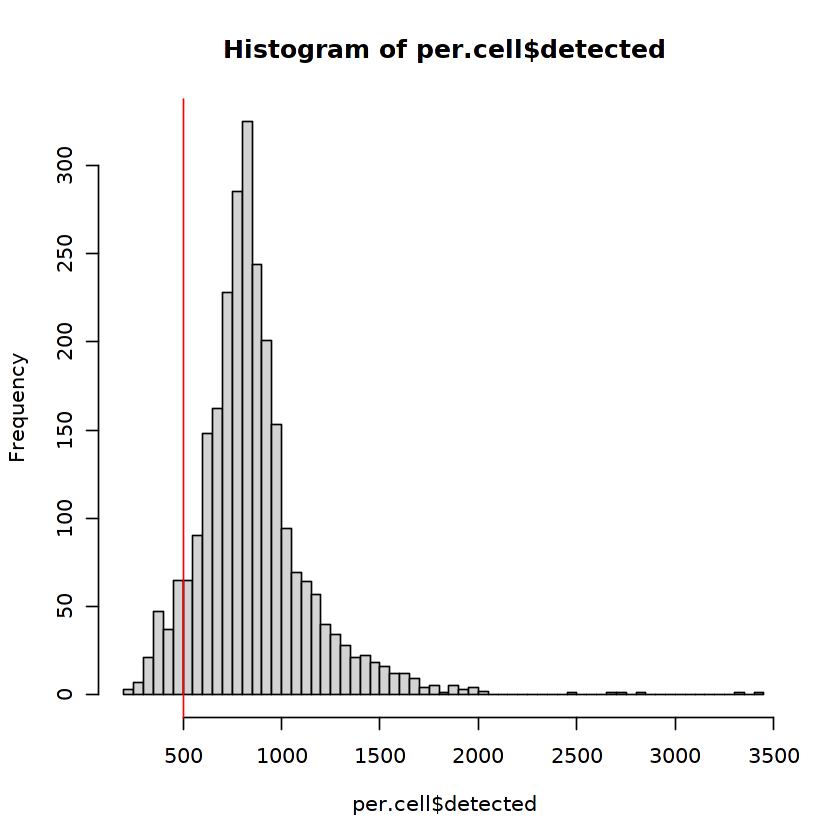

In [70]:
hist(
    per.cell$detected,
    breaks = 100
)
abline(v = 500, col = "red")

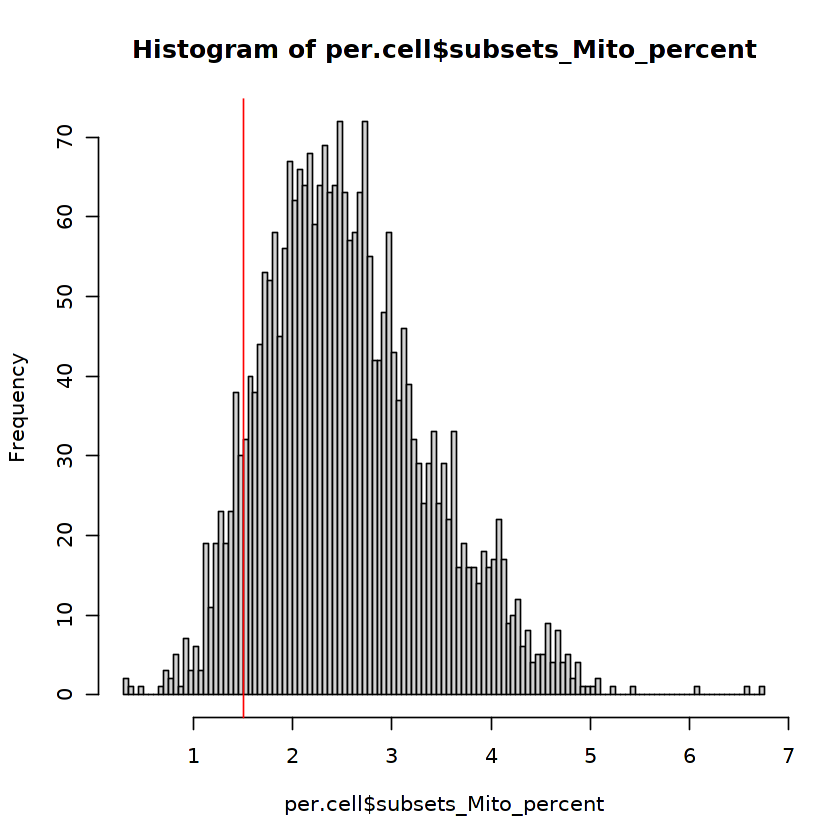

In [68]:
hist(
    per.cell$subsets_Mito_percent,
    breaks = 100
)
abline(v = 1.5, col = "red")

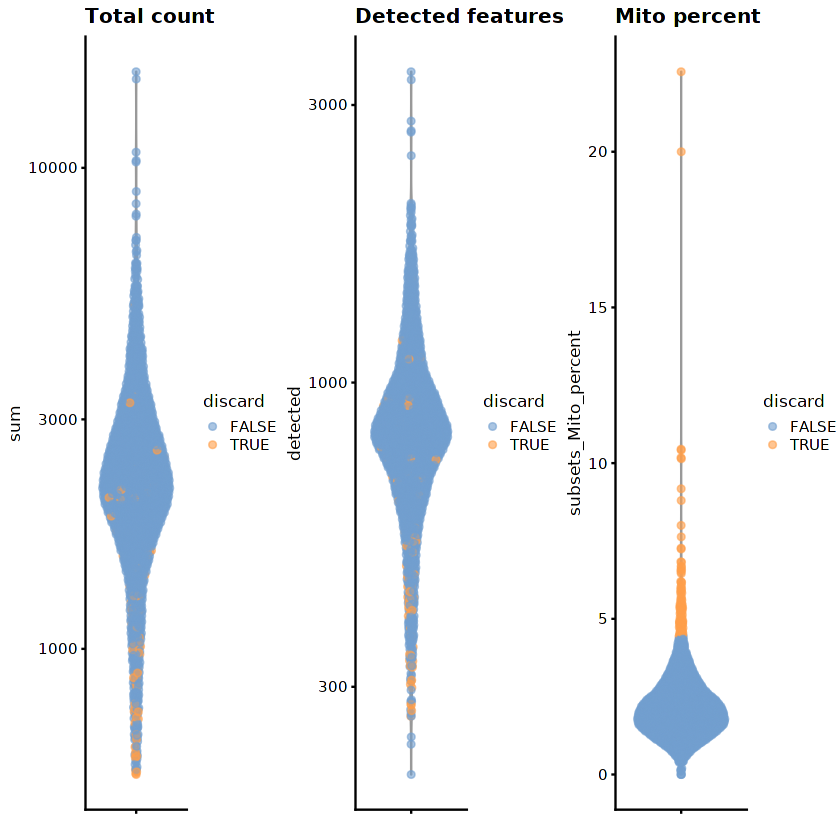

In [28]:
colData(unfiltered) <- cbind(colData(unfiltered), stats)
unfiltered$discard <- high.mito

gridExtra::grid.arrange(
    plotColData(unfiltered, y="sum", colour_by="discard") +
        scale_y_log10() + ggtitle("Total count"),
    plotColData(unfiltered, y="detected", colour_by="discard") +
        scale_y_log10() + ggtitle("Detected features"),
    plotColData(unfiltered, y="subsets_Mito_percent",
        colour_by="discard") + ggtitle("Mito percent"),
    ncol=3
)

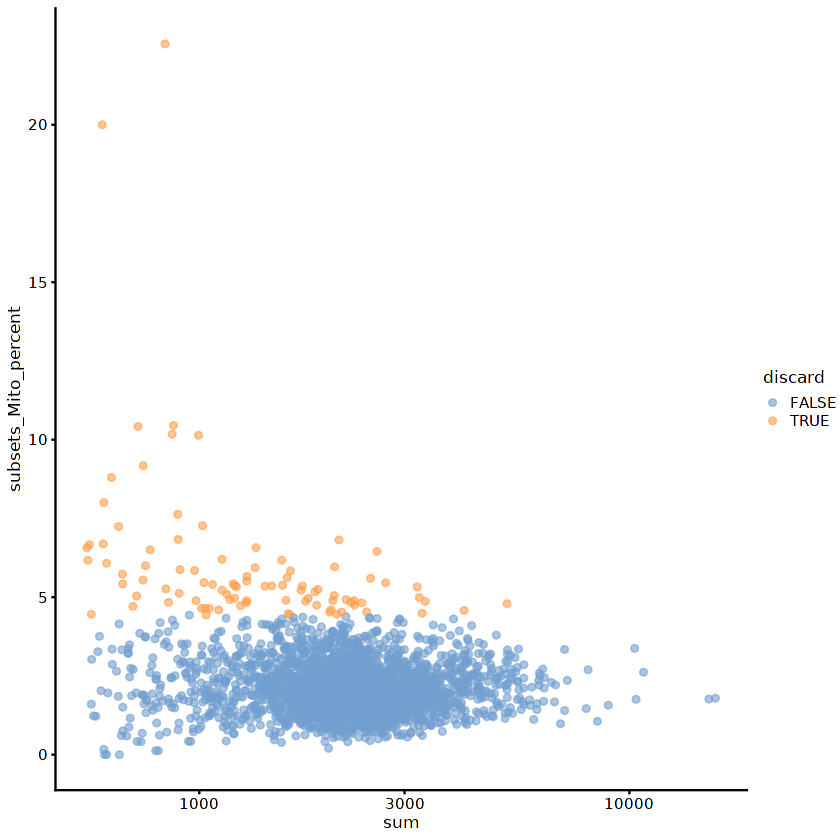

In [29]:
plotColData(unfiltered, x="sum", y="subsets_Mito_percent",
    colour_by="discard") + scale_x_log10()

In [30]:
library(scran)
set.seed(1000)
clusters <- quickCluster(sce)
sce <- computeSumFactors(sce, cluster=clusters)
sce <- logNormCounts(sce)

In [31]:
summary(sizeFactors(sce))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1477  0.7312  0.9190  1.0000  1.1407  9.0340 

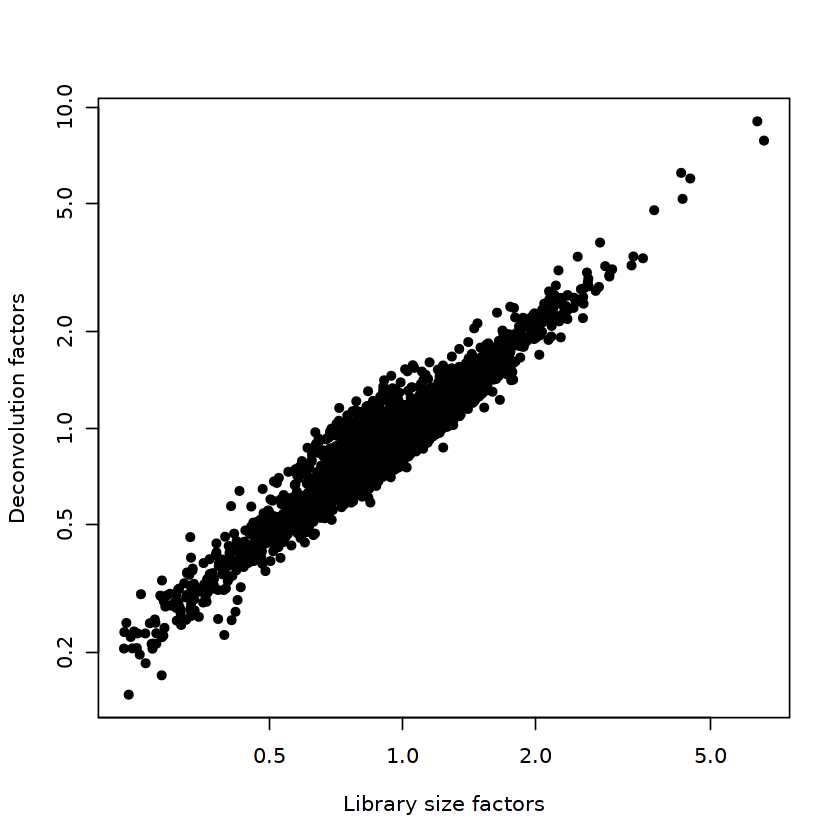

In [32]:
plot(librarySizeFactors(sce), sizeFactors(sce), pch=16,
    xlab="Library size factors", ylab="Deconvolution factors", log="xy")